# Studying the humidity profile uncertainty during positive and negative phases of El Niño Southern Oscillations

### Quality question:
 - __What is the uncertainty of the observed satellite humidity profiles during positive and negative ENSO phases in the deep tropics?__


Water vapor is one of the most significant greenhouse gases, accounting for about 50% of the total greenhouse warming effect[[1]](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2010JD014287). A critical factor that drives water vapor warming is its vertical distribution throughout the troposphere. Humidity profiles strongly influence the Earth's total energy budget. Moreover, humidity profiles both control and influence weather and climate processes.

One of the primary drivers of climate variability is the El Niño Southern Oscillation (ENSO). <!--ENSO significantly impacts humidity profiles by altering the spatial distribution and intensity of convection over the tropics. -->
The ENSO cycle has two distinct phases: positive (El Niño) and negative (La Niña). During the positive phase, El Niño, warmer-than-average sea surface temperatures occur in the central and eastern Pacific Ocean, leading to increased atmospheric convection and higher humidity levels. Conversely, the negative phase, La Niña, is characterized by cooler-than-average sea surface temperatures in the same regions, which suppresses convection and results in drier conditions.
As a result, the tropical-averaged humidity profile is markedly influenced by both ENSO phases.

This analysis make use of the dataset [__Tropospheric humidity proﬁles averaged monthly and zonally from
2006 to present derived from satellite observations__](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-humidity-profiles), which provides monthly and zonally averaged tropospheric humidity proﬁles derived from globally distributed GPS radio occultation (RO) measurements from EUMETSAT's Metop polar-orbiting satellites [[2]](https://amt.copernicus.org/articles/13/3081/2020/). The dataset is available on the Copernicus Data Store (CDS).

This notebook illustrates the relationship between ENSO and humidity profiles. Additionally, the analysis aims to verify if the results align with previous studies [[3]](https://journals.ametsoc.org/view/journals/clim/35/21/JCLI-D-21-0884.1.xml) to ensure the quality of the satellite dataset that is used.


## Quality assessment statement 

These are the key outcomes of this assessment

- The uncertainties in the humidity profiles are similar during both positive and negative ENSO conditions. The uncertainty is small in the lower troposphere (about 1%) and increases with altitude, reaching about 3% in the free troposphere.

- A significant increase (during positive ENSO) or decrease (during negative ENSO) in humidity is observed at all levels of the troposphere. The deviation from the mean becomes larger with altitude.

- The results are consistent with those reported in [[3]](https://journals.ametsoc.org/view/journals/clim/35/21/JCLI-D-21-0884.1.xml), confirming the reliability and accuracy of the satellite dataset utilized in this analysis.


## Methodology

The ENSO oscillation primarily affects humidity and convection during the boreal winter season. Therefore, this analysis focuses on humidity profiles from that season. We examine two specific case studies: the December-January-February period of 2015-2016 to illustrate positive ENSO conditions, and the December-January-February period of 2010-2011 to illustrate negative ENSO conditions.

Initially, humidity profiles for all boreal winters from 2006 to 2024 are downloaded from the Climate Data Store. Climatological profiles are then computed for the deep tropics (10°S-10°N). To quantify the deviation from neutral conditions, the ratio between the humidity profile of each case study and the climatological profile is calculated:
\begin{align}
R^+(z) &= \frac{H(z, t = 2015\text{-}2016)}{<H(z)>_{time}}\\
R^-(z) &= \frac{H(z, t = 2010\text{-}2011)}{<H(z)>_{time}}
\end{align}
where H(z, t) is the humidity profile at time $t$, and $<H(z)>_{time}$ si the climatological boreal winter humidity profile.

The dataset provides two different types of uncertainties: the measurement error is the uncertainty of the individual profiles propagated to the monthly mean, the sampling error is the uncertainty coming from under-sampling the atmospheric variability. The two uncertainties are independentand they are combined in order to have a more complete uncertainty value.
$$\text{total uncertainty
} = \sqrt{(\text{measurement error})^2 + (\text{sampling error})^2}$$


The analysis comprises the following steps:

__1. [Choose the parameters to use and setup code](#Choose-the-parameters-to-use-and-setup-code)__
 - Import the relevant packages. Define the parameters of the analysis and set the dataset requests

__2. [Download the dataset](#Download-the-dataset)__
 - Download the zonally mean humidity profiles and the associated uncertainties for the December-January-February period provided by the CDS.

__3. [Results](#Results)__
 - The climatological humidity profile for the deep tropics during the boreal winter season is computed and visualized. 
 - The ratio of the humidity profiles for the two case studies to the climatological mean is calculated and displayed.


## Analysis and Results

### Choose the parameters to use and setup code

#### Import packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
from c3s_eqc_automatic_quality_control import download

plt.style.use("seaborn-v0_8-notebook")

import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/mandorli_giulio/.cdsapirc")

#### Define parameters

In [2]:
# Time
start = "2007-01"
stop = "2024-02"

# Latitude band
lat_min=-10
lat_max=10

# Case studies and associated colors
colors = dict()
colors['2015'] = 'darkred'
colors['2010'] = 'darkblue'

# Case studies
years = list(colors.keys())


#### Set the data request

In [3]:
collection_id = 'satellite-humidity-profiles'

request =  {
        'variable': 'all',
        'product_type': 'radio_occultation_data', 
        'year': list(range(2006, 2024)),
        'month': ['01', '02', '12'],
}

### Download the dataset

In [4]:
ds_profiles = download.download_and_transform(
    collection_id,
    request,
)

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


### Results

#### Climatological humidity profile for Dec-Jan-Feb

In [5]:
ds = ds_profiles.sel(alt=slice(0,12000)).mean('longitude')
ds_deep_tropics = ds.sel(latitude=slice(lat_min,lat_max))
ds_deep_tropics_mean = ds_deep_tropics.mean(['latitude', 'time'])

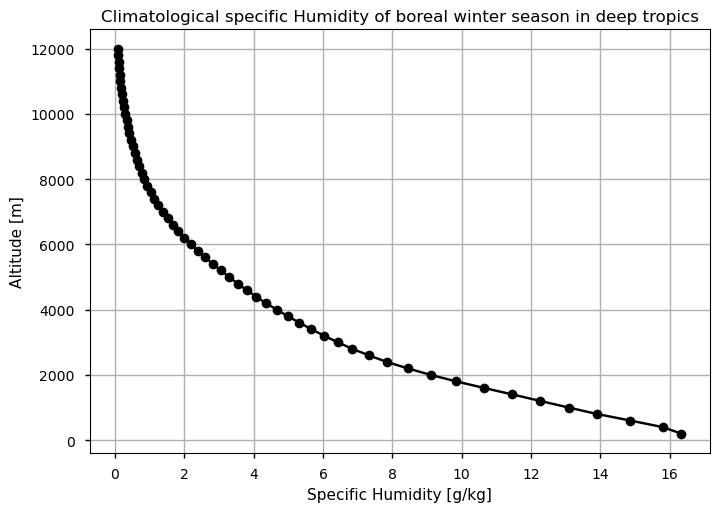

In [6]:
plt.plot(ds_deep_tropics_mean["Q"], ds_deep_tropics_mean["alt"], c='k', marker='o')

plt.xlabel('Specific Humidity [g/kg]')
plt.ylabel('Altitude [m]')
plt.title('Climatological specific Humidity of boreal winter season in deep tropics')
plt.grid(True)
plt.show()

_This figure displays the climatological specific humidity profile from the surface up to 12 km during the boreal winter season in the deep tropics. The average is calculated over the period from 2006 to 2024. The profile has an approximately exponential shape, which can be explained by combining the Clausius-Clapeyron equation and the nearly constant lapse rate._

#### Humidity profile for positive and negative ENSO conditions

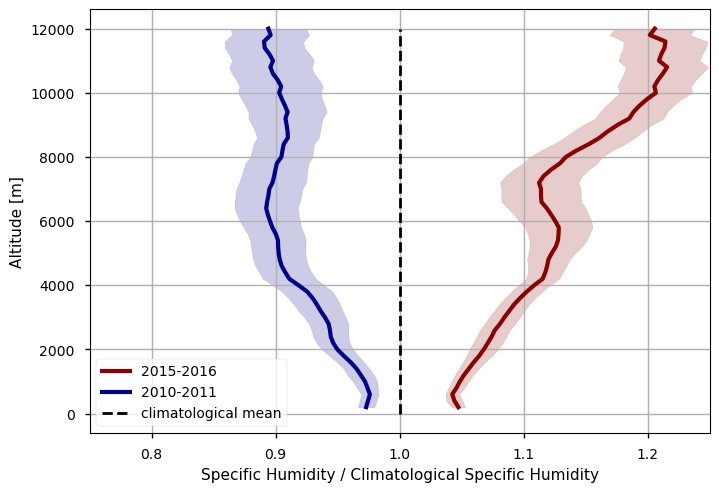

In [7]:
for yy in years :
    t_slice = slice(f'{yy}-12-01', f'{int(yy)+1}-02-28')
    data_selected = ds_deep_tropics.sel(time=t_slice)
    data = data_selected.mean(['latitude', 'time'])
    data['error'] = np.sqrt( (data_selected['Q_samperr']**2  + \
                              data_selected['Q_obssig']**2).mean(['latitude', 'time']) ) 

    plt.fill_betweenx( data["alt"],
                       (data["Q"] - data["error"]) / ds_deep_tropics_mean["Q"], 
                       (data["Q"] + data["error"]) / ds_deep_tropics_mean["Q"], 
                       color=colors[yy], alpha=0.2)
    plt.plot(data["Q"] / ds_deep_tropics_mean["Q"],
             data["alt"],
             c=colors[yy], lw=3, label=f'{yy}-{int(yy)+1}')


plt.plot([1,1], [0,12000], color='k', linestyle='--', linewidth=2, label='climatological mean')

plt.legend(loc='lower left')

plt.xlabel('Specific Humidity / Climatological Specific Humidity')
plt.ylabel('Altitude [m]')
plt.grid(True)
plt.xlim([0.75,1.25])
plt.show()


_This figure shows the  the ratio of the specific humidity profile over the climatological humidity profile from the surface up to 12 km during two main ENSO events in the deep tropics. The red curve represent the positive ENSO conditions during the boreal winter 2015-2016. The blue line represent the negative ENSO condition during the boreal winter 2010-2011. The shaded area represent the average uncertainty of each profile._

The figure shows the humidity profiles during positive and negative ENSO events. During the positive ENSO event in the boreal winter of 2015-2016, the troposphere is significantly wetter than under neutral conditions, with deviations ranging from 5% to 20%, increasing with altitude. In contrast, during the negative ENSO event in the boreal winter of 2010-2011, the troposphere is significantly drier than neutral conditions, with deviations ranging from 3% to 10%.

The uncertainties for the two profiles are similar. In the lower troposphere, the uncertainty is relatively small, approximately 1%. However, as altitude increases, the uncertainty also increases, reaching about 3% in the free troposphere. This gradient in uncertainty highlights the greater variability and measurement challenges at higher altitudes compared to the more stable conditions near the surface.

## If you want to know more
### Key resources
Some key resources and further reading were linked throughout this assessment.

The CDS catalogue entry for the data used is:
- Tropospheric humidity proﬁles averaged monthly and zonally from 2006 to present derived from satellite observations:
https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-humidity-profiles

Code libraries used:
- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [BOpen](https://www.bopen.eu/)


### Reference/Useful material

[[1]](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2010JD014287) Schmidt, G. A., R. A. Ruedy, R. L. Miller, and A. A. Lacis (2010), Attribution of the present-day total greenhouseeﬀect,J. Geophys. Res.,115, D20106, doi:10.1029/2010JD014287.

[[2]](https://amt.copernicus.org/articles/13/3081/2020/) Gleisner, H., Lauritsen, K. B., Nielsen, J. K., and Syndergaard, S., Evaluation of the 15 year ROM SAF monthly mean GPS radio occultation climate data record, Atmos. Meas. Tech., 13, 3081-3098, doi:10.5194/amt-13-3081-2020.

[[3]](https://doi.org/10.1175/JCLI-D-21-0884.1) Johnston, B. R., W. J. Randel, and J. J. Braun, 2022: Interannual Variability of Tropospheric Moisture and Temperature and Relationships to ENSO Using COSMIC-1 GNSS-RO Retrievals. J. Climate, 35, 7109–7125. 

